In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from pandas_profiling import ProfileReport

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
df=pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv")

In [4]:
df.head() #binary class classification problem.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.shape

(768, 9)

In [6]:
#ProfileReport(df)

#In the above EDA Report we saw that the Glucose, BloodPRessure, SkinThinckness, Insulin columns has zero values, which is impossible. As this kind of parameter cannot be zero at all. It might be cause of unknown data or system failure. That's why we have to change the data with the proper data.

In [7]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [8]:
df["BMI"]=df["BMI"].replace(0, df["BMI"].mean())  #If our dataset is skewed we cannot be dependent on median or mode.
#That's why we have used mean over here.

In [9]:
df["BloodPressure"]=df["BloodPressure"].replace(0, df["BloodPressure"].mean())

In [10]:
df["SkinThickness"]=df["SkinThickness"].replace(0, df["SkinThickness"].mean())

In [11]:
df["Glucose"]=df["Glucose"].replace(0, df["Glucose"].mean())

In [12]:
df["Insulin"]=df["Insulin"].replace(0, df["Insulin"].mean())

In [13]:
#ProfileReport(df)

In [14]:
#Checking for the outliers.
#if we have certain type of skewness in our dataset then we might have outiler in the dataset.

<AxesSubplot:>

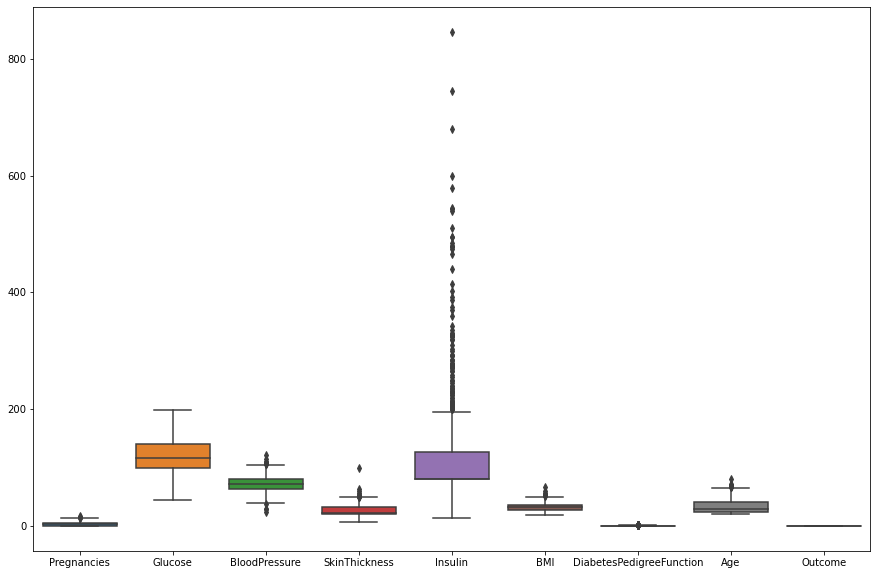

In [15]:
fig, ax= plt.subplots(figsize=(15,10))
sns.boxplot(data=df, ax=ax)

In [16]:
def outlier_removal(data):
    def outlier_limits(col):
        Q3,Q1= np.nanpercentile(col, [75,25])
        IQR=Q3-Q1
        UL=Q3+1.5*IQR
        LL=Q1-1.5*IQR
        return UL, LL
    for column in df.columns:
        if df[column].dtypes!='int64':
            UL,LL=outlier_limits(df[column])
            df[column]=np.where((df[column]>UL)| (df[column]<LL), np.nan, df[column])
    return df

In [17]:
df=outlier_removal(df)

In [18]:
df.isnull().sum()

Pregnancies                  0
Glucose                      0
BloodPressure               14
SkinThickness               12
Insulin                     89
BMI                          8
DiabetesPedigreeFunction    29
Age                          0
Outcome                      0
dtype: int64

In [19]:
def fillna(x):
    if df.isna().any().any():
        df.fillna(df.median(), inplace=True)
    return df
fillna(df)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,0.356,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.000000,180.000000,32.9,0.171,63,0
764,2,122.0,70.0,27.000000,79.799479,36.8,0.340,27,0
765,5,121.0,72.0,23.000000,112.000000,26.2,0.245,30,0
766,1,126.0,60.0,20.536458,79.799479,30.1,0.349,47,1


<AxesSubplot:>

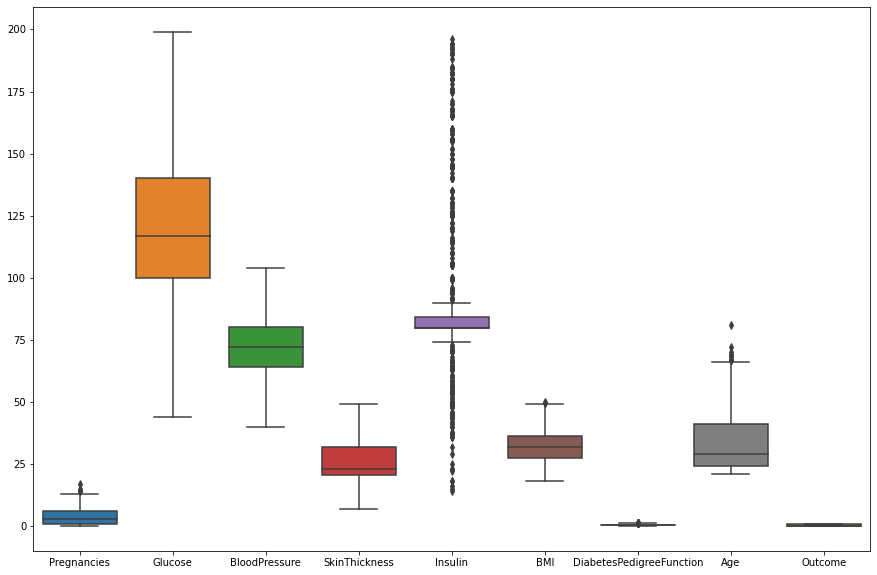

In [20]:
fig, ax= plt.subplots(figsize=(15,10))
sns.boxplot(data=df, ax=ax)

In [21]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,0.356,33,1


In [22]:
X= df.drop("Outcome",axis=1)
y=df["Outcome"]

In [23]:
#scaling the data 
scaler=StandardScaler()
X_scaled= pd.DataFrame(scaler.fit_transform(X))

<AxesSubplot:>

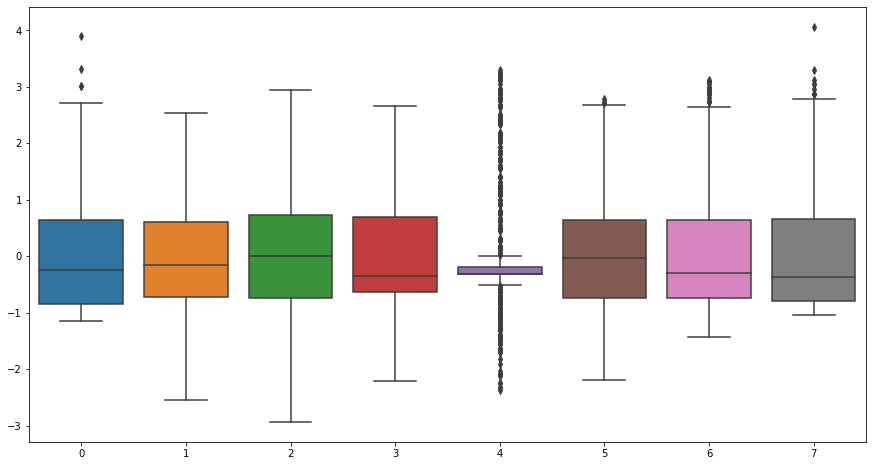

In [24]:
fig, ax= plt.subplots(figsize=(15, 8))
sns.boxplot(data=X_scaled, ax=ax)

<AxesSubplot:>

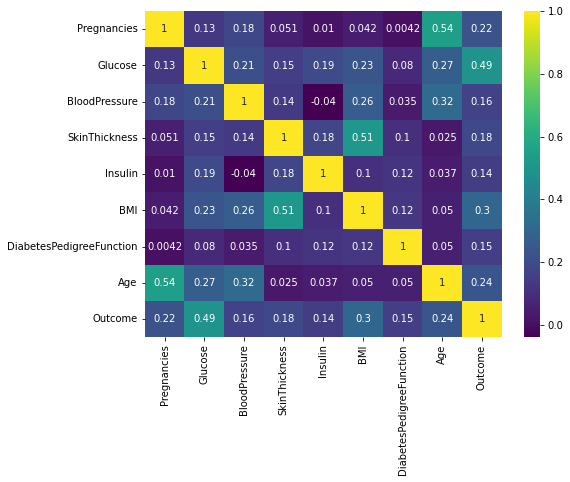

In [25]:
#check for multicollinearity
fig, ax= plt.subplots(figsize=(8,6))
sns.heatmap(df.corr(),yticklabels=True, cbar=True, cmap="viridis", annot=True)

In [26]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21
4,0,137.0,40.0,35.000000,168.000000,43.1,0.356,33


In [27]:
def vif_score(x):
    scaler=StandardScaler()
    arr=scaler.fit_transform(x)
    return pd.DataFrame([[x.columns[i],variance_inflation_factor(arr,i)] for i in range(arr.shape[1])],columns=["Feature","Vif_score"])
    

In [28]:
vif_score(X)

,Feature,Vif_score
0,Pregnancies,1.426765
1,Glucose,1.180835
2,BloodPressure,1.213635
3,SkinThickness,1.395947
4,Insulin,1.084909
5,BMI,1.478469
6,DiabetesPedigreeFunction,1.031756
7,Age,1.604388


#There is no multicollinearity.

In [29]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=144)

In [30]:
y_train

257    0
758    0
74     0
685    0
25     1
      ..
643    0
422    0
216    1
444    1
359    1
Name: Outcome, Length: 614, dtype: int64

## 1st Model

In [31]:
clf=LogisticRegression(verbose=1)
clf.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(verbose=1)

When verbose is turned on, the algorithm will provide more detailed information about its progress as your model iterates through the training process.

In [32]:
X_test.shape,y_test.shape

((154, 8), (154,))

In [33]:
X_train.shape, y_train.shape

((614, 8), (614,))

In [34]:
clf.predict_proba([X_test.iloc[0]])  #this will give the probability.
#It is showing that the label have 0.70% to be 0 and 0.29% to be 1.

array([[0.70916479, 0.29083521]])

In [35]:
y_test

401    0
49     0
734    0
377    0
521    0
      ..
478    0
331    0
120    1
66     1
357    1
Name: Outcome, Length: 154, dtype: int64

In [41]:
clf.predict([X_test.iloc[0]]) #it is giving the prediction of the oth index of X_test to be 0.

array([0], dtype=int64)

In [51]:
clf.predict([X_test.iloc[5]]) #it is giving the prediction of the 5th index of X_test to be

array([1], dtype=int64)

In [69]:
y_pred_default=clf.predict(X_test)

In [70]:
y_pred_default

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
      dtype=int64)

In [52]:
print(y_test.iloc[5])

1


In [53]:
clf.predict_log_proba([X_test.iloc[1]])

array([[-0.23320377, -1.57017958]])

## 2nd Model

In [ ]:
#Solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’

"Algorithm to use in the optimization problem. Default is ‘lbfgs’."

#For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;

#For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;

#‘liblinear’ is limited to one-versus-rest schemes.

#‘newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories.

In [57]:
clf1=LogisticRegression(verbose=1, solver= "liblinear" )
clf1.fit(X_train,y_train)

[LibLinear]

LogisticRegression(solver='liblinear', verbose=1)

In [58]:
clf1.predict_proba([X_test.iloc[0]]) 

array([[0.70706295, 0.29293705]])

In [65]:
y_pred_liblinear=clf1.predict(X_test)

In [66]:
y_pred_liblinear

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
      dtype=int64)

In [67]:
confusion_matrix(y_test,y_pred_liblinear)

array([[93,  7],
       [22, 32]], dtype=int64)

In [71]:
confusion_matrix(y_test,y_pred_default)

array([[93,  7],
       [22, 32]], dtype=int64)

In [74]:
def model_eval(y_true,y_pred):
    tn,fp,fn,tp= confusion_matrix(y_test,y_pred).ravel()
    accuracy=(tp+tn)/(tp+tn+fp+fn)
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    specificity=tn/(fp+tn)
    result={"Accuracy":accuracy,"Precision":precision,"Recall":recall,"Specificity":specificity}
    return result
model_eval(y_test,y_pred_liblinear)

{'Accuracy': 0.8116883116883117,
 'Precision': 0.8205128205128205,
 'Recall': 0.5925925925925926,
 'Specificity': 0.93}

In [76]:
auc = roc_auc_score(y_test,y_pred_liblinear)

In [77]:
roc_auc_score(y_test,y_pred_default)

0.7612962962962962

In [78]:
fpr, tpr, thresholds  = roc_curve(y_test,y_pred_liblinear)

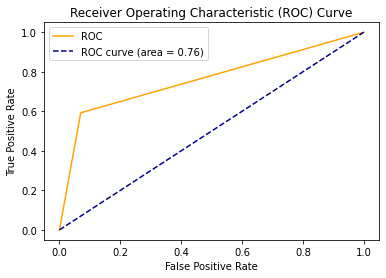

In [79]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()